# Проект по анализу данных с сайта ОСН (Общественная служба новостей)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


В данном шаге нам необходимо провести основные описательные статистики + визуальный анализ данных. Важно отметить интересные моменты в наших данных до проведения исследования:
- определить особенности выборки по результатам первичного анализ, удаление выбросов и т.д.
- отметить моменты, которые позволят до проведения расчетов и построения моделей, выдвинуть несколько гипотез/предположений о результатах следующих этапов и т.д.
---
Также необходимо сделать:

- Очистку текстов от ненужных элементов
- Приведение столбца 'datetime' к формату даты
- Распределение по разделам
- Распределение времени новостей
- Распределение по длине заголовка
- Распределение по длине текста
- Ключевые слова по каждой из тематик

In [49]:
df = pd.read_csv('c://Users/User/Downloads/articles_osn.csv')

In [50]:
df.tail(3)

,url,title,topic,content,datetime
11830,https://www.osnmedia.ru/?post_type=post&p=1461981,"В Пятигорске предъявили обвинения дворнику, по...",\n\nПроисшествия\n,"25 октября 2023, 18:58 — Общественная служба...","25 октября 2023, 18:58 — Общественная служба н..."
11831,https://www.osnmedia.ru/?post_type=post&p=1461974,Летевший на Алтай пассажирский самолет начали ...,\n\nПроисшествия\n,"25 октября 2023, 18:54 — Общественная служба...","25 октября 2023, 18:54 — Общественная служба н..."
11832,https://www.osnmedia.ru/?post_type=post&p=1461963,В Белгородской области пресекли канал поставок...,\n\nПроисшествия\n,"25 октября 2023, 18:21 — Общественная служба...","25 октября 2023, 18:21 — Общественная служба н..."


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11833 entries, 0 to 11832
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   url       11833 non-null  object
 1   title     11833 non-null  object
 2   topic     11833 non-null  object
 3   content   11833 non-null  object
 4   datetime  11833 non-null  object
dtypes: object(5)
memory usage: 462.4+ KB


In [52]:
df.duplicated().value_counts()


False    11587
True       246
Name: count, dtype: int64

In [53]:
df = df.drop_duplicates(ignore_index=True)

In [54]:
len(df)

11587

Для начала мы очистим тексты статей из признака `content` от даты, а из самого признака с датой уберём строку " - Общественная служба новостей".

In [55]:
for i in range(len(df)):
      df['content'][i] = df['content'][i].replace(str(df['datetime'][i]), '')
      df['datetime'][i] = df['datetime'][i].replace('— Общественная служба новостей — ОСН', '')

Для удобства работы, мы уберём из названий разделов символы переноса строки '\n'.

In [56]:
df['topic'] = df['topic'].str.replace('\n', '')

In [57]:
df.topic.value_counts()

topic
Общество        2942
Политика        1816
Происшествия    1698
Экономика       1691
Спорт           1673
Культура        1670
Эксклюзив         92
Главное            2
Картина дня        2
Безопасность       1
Name: count, dtype: int64

C:\Users\User\AppData\Local\Temp\ipykernel_15612\3986827379.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




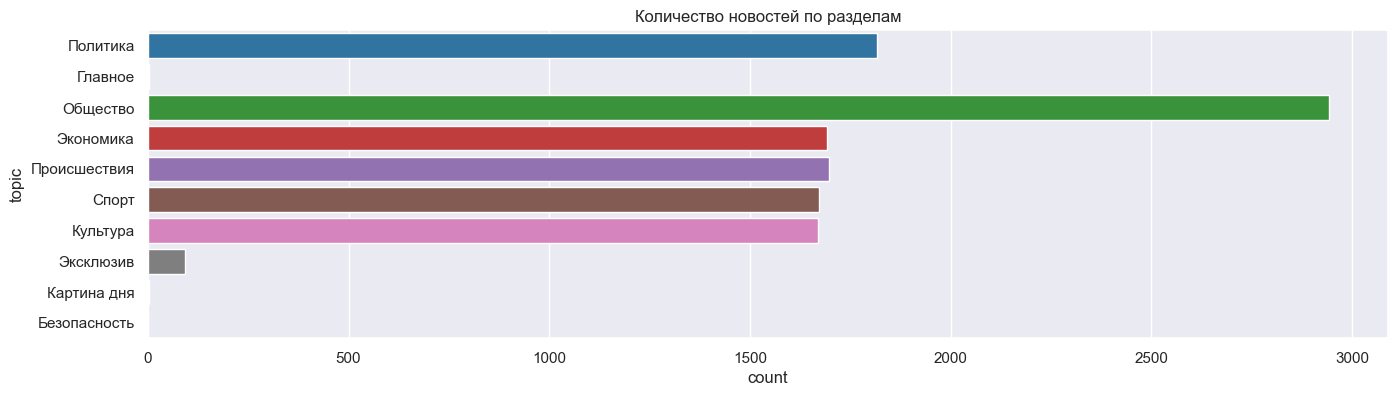

In [58]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16,4))
sns.countplot(y=df['topic'], palette='tab10', ax=ax)
plt.title('Количество новостей по разделам');

Мы видим, что в разделах "Картина дня", "Безопасность" и "Главное" всего по 1 и 2 статьи.  В разделе "Эксклюзив" тоже всего 92 статьи. Избавимся от этих разделов, так как они составляют менее 1% от датасета и усложнят работу задачи классификации.

In [59]:
df = df.loc[~df.topic.isin(['Безопасность', 'Картина дня', 'Главное', 'Эксклюзив'])]

In [60]:
df.topic.value_counts()

topic
Общество        2942
Политика        1816
Происшествия    1698
Экономика       1691
Спорт           1673
Культура        1670
Name: count, dtype: int64

Мы видим, что больше всего статей в разделе "Общество" - почти в два раза больше, чем в любом другом разделе. Остальные разделы примерно одинаковы по размерам.

Приведём признак с датой к формату 'datetime'

In [61]:
def replace_date_string(date_string):
  date_format = '%d %B %Y, %H:%M '
  month_names = {
      'января': 'January',
      'февраля': 'February',
      'марта': 'March',
      'апреля': 'April',
      'мая': 'May',
      'июня': 'June',
      'июля': 'July',
      'августа': 'August',
      'сентября': 'September',
      'октября': 'October',
      'ноября': 'November',
      'декабря': 'December'
    }

  for ru_month, en_month in month_names.items():
      try:
        date_string = date_string.replace(ru_month, en_month)
      except ValueError:
         print(date_string)

  datetime_object = datetime.strptime(date_string, date_format)
  return datetime_object

In [62]:
df.datetime

0         15 ноября 2023, 23:39  
1         15 ноября 2023, 22:56  
2         15 ноября 2023, 22:48  
3         15 ноября 2023, 20:58  
4         15 ноября 2023, 20:50  
                   ...           
11582    25 октября 2023, 19:15  
11583    25 октября 2023, 18:59  
11584    25 октября 2023, 18:58  
11585    25 октября 2023, 18:54  
11586    25 октября 2023, 18:21  
Name: datetime, Length: 11490, dtype: object

In [63]:
df['datetime'] = df['datetime'].apply(replace_date_string)

Теперь мы можем создать новые признаки с месяцом и днём недели для визуализации.

In [64]:
df['month'] = df['datetime'].dt.strftime("%B")
df['weekday'] = df['datetime'].dt.strftime('%A')

In [65]:
df.head()

,url,title,topic,content,datetime,month,weekday
0,https://www.osnmedia.ru/?post_type=post&p=1486489,Пленный боец ВСУ Пиявка отказался от обмена и ...,Политика,Пленный боец Десятой горно-штурмовой бригады...,2023-11-15 23:39:00,November,Wednesday
1,https://www.osnmedia.ru/?post_type=post&p=1486441,Глава МИД Чехии: Заморозка собственности РФ не...,Политика,Заморозка государственной собственности Росс...,2023-11-15 22:56:00,November,Wednesday
2,https://www.osnmedia.ru/?post_type=post&p=1486397,Экс-морпех Берлетик: Владимира Зеленского могу...,Политика,Бывший морской пехотинец ВС США Брайан Берле...,2023-11-15 22:48:00,November,Wednesday
3,https://www.osnmedia.ru/?post_type=post&p=1486326,Экс-депутат Рады Мосийчук*: ВС РФ нанесли удар...,Политика,Ракетному удару со стороны российских военны...,2023-11-15 20:58:00,November,Wednesday
4,https://www.osnmedia.ru/?post_type=post&p=1486318,Россиянка Юлия Шандогли рассказала о спасении ...,Политика,"Гражданка РФ Юлия Шандогли, которую эвакуиро...",2023-11-15 20:50:00,November,Wednesday


C:\Users\User\AppData\Local\Temp\ipykernel_15612\2423820596.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\User\AppData\Local\Temp\ipykernel_15612\2423820596.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




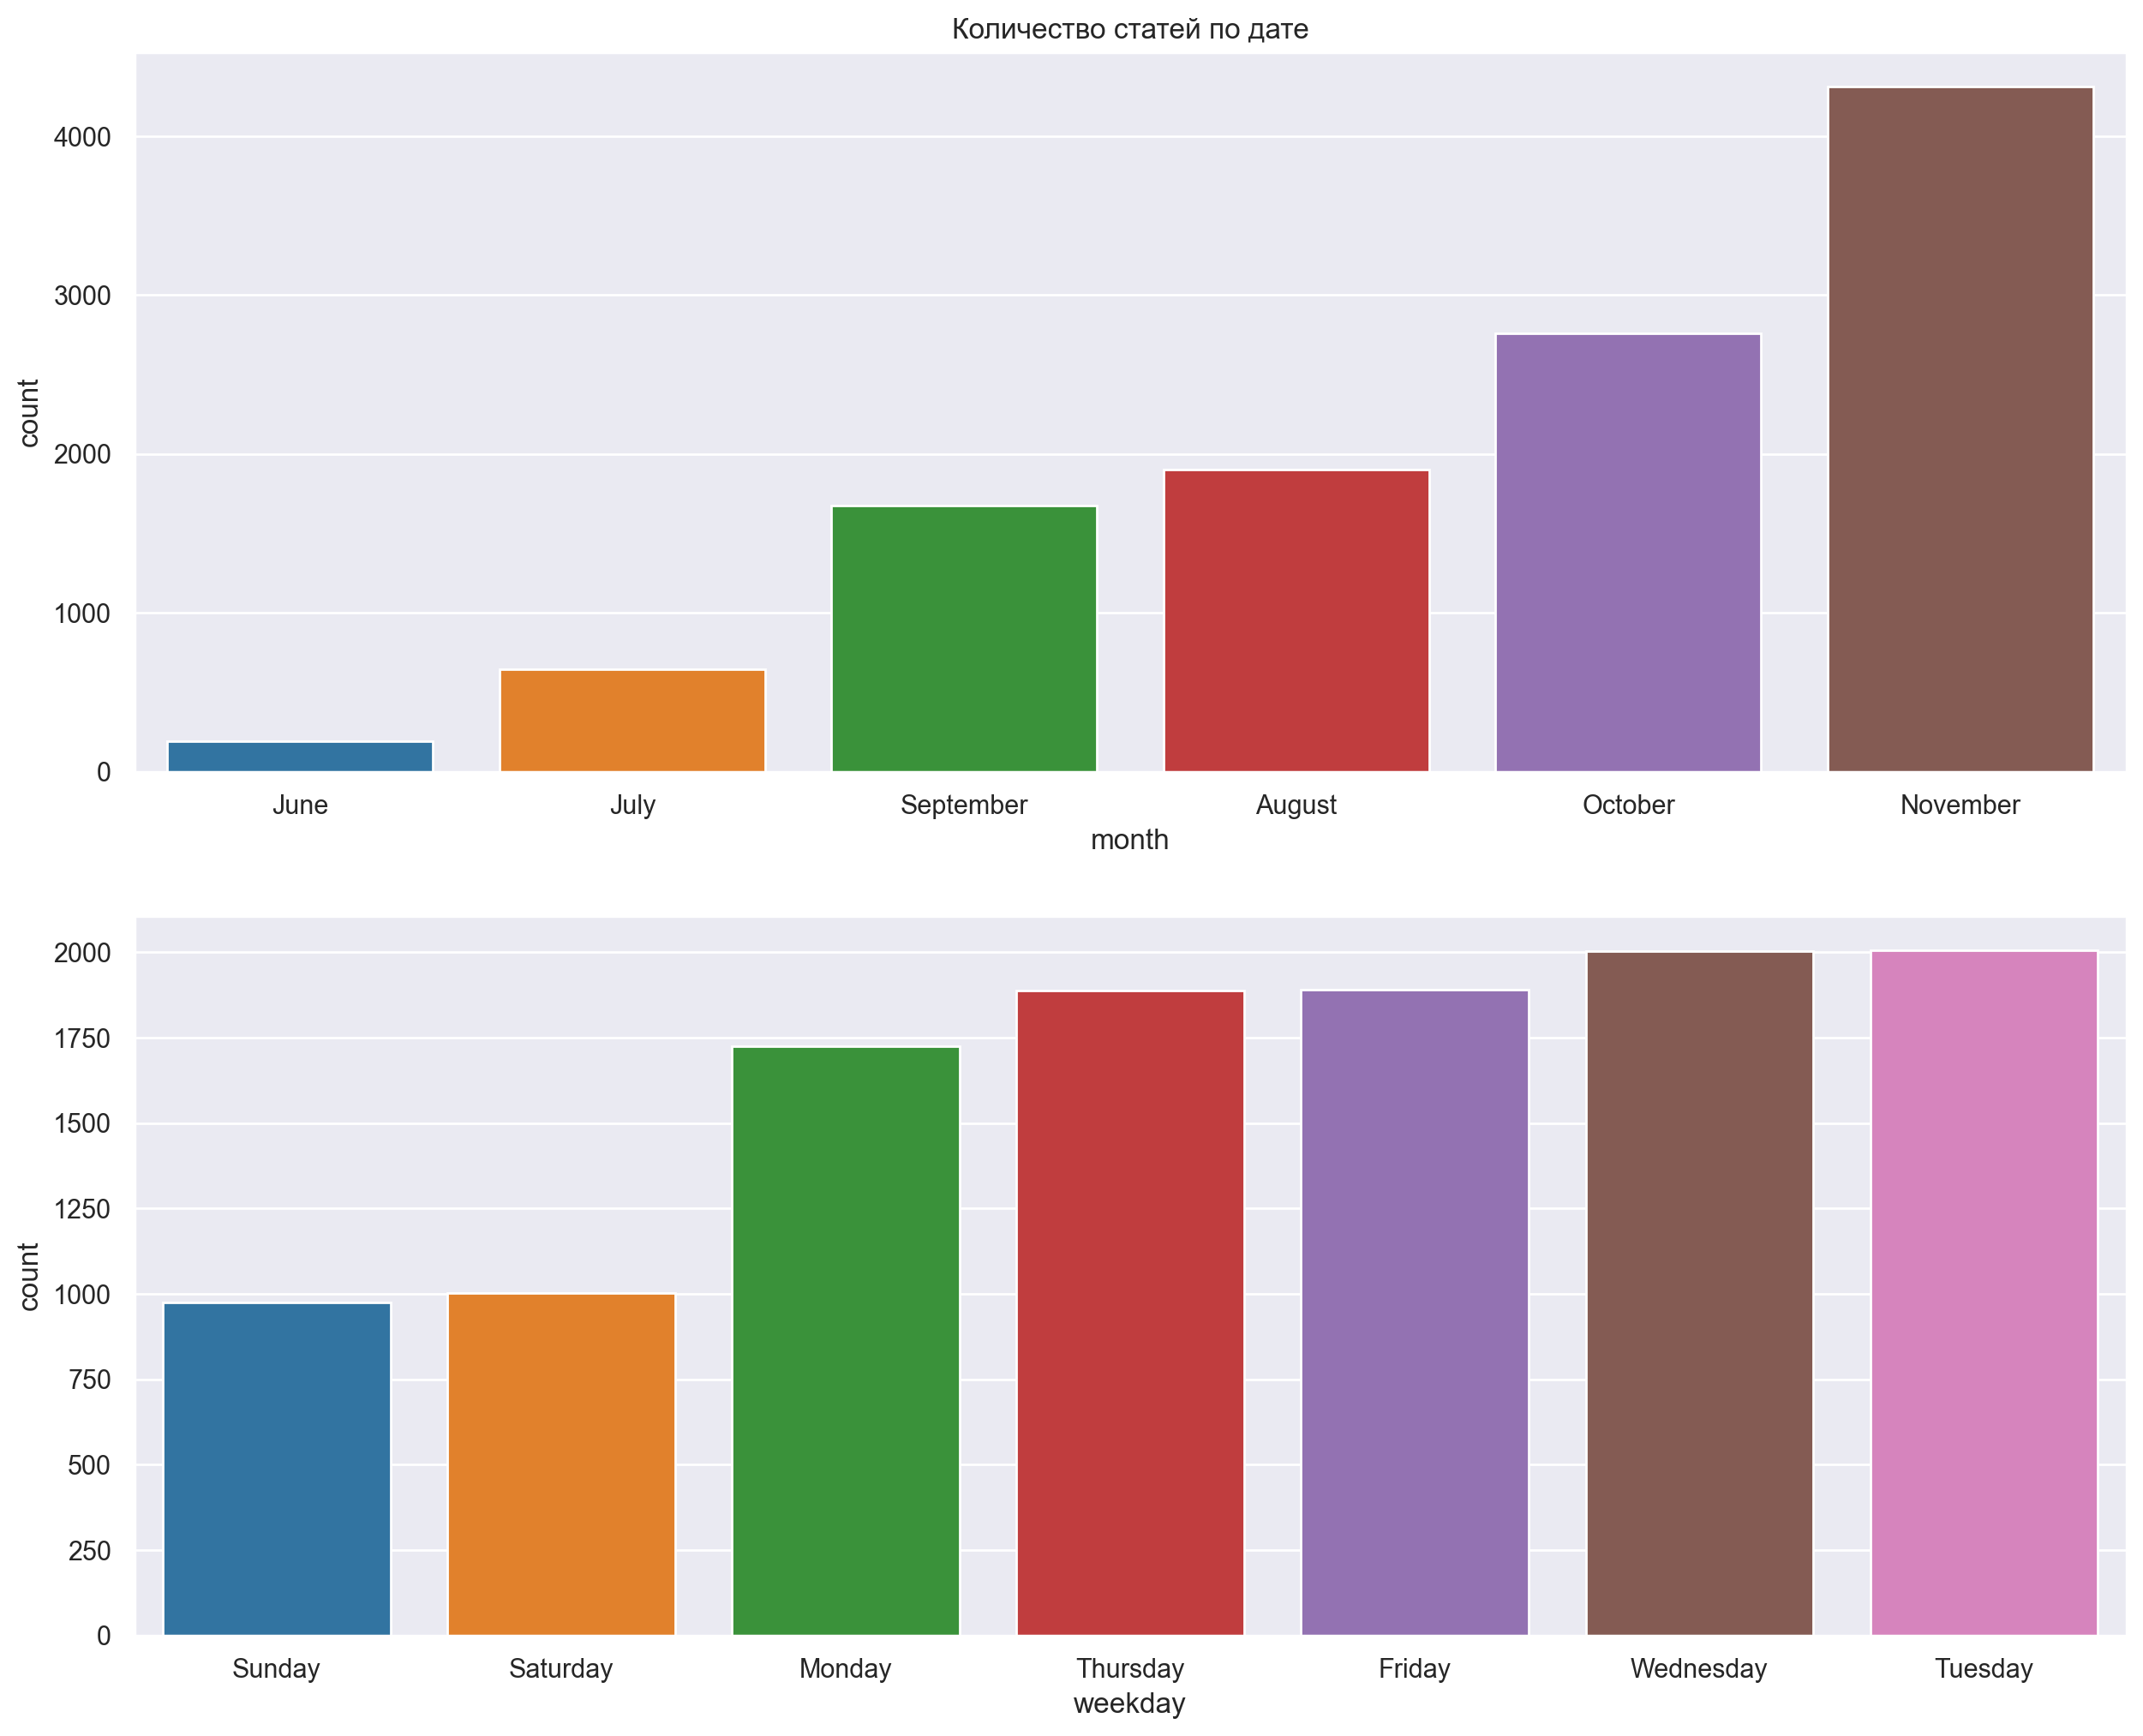

In [66]:
fig, axs = plt.subplots(2, 1, figsize=(15, 12), dpi=200)
for ind, col in enumerate(['month', 'weekday']):
    sns.countplot(x=df[col], palette='tab10', ax=axs[ind], order=df[col].value_counts(ascending=True).index)
axs[0].set_title('Количество статей по дате');

Очевидным образом, больше всего статей было выпущено в ноябре, так как парсили сайт мы 16 ноября 2023 года. Интересно отметить, что больше всего новостей на сайте ОСН выпускалось во вторник и среду, а меньше всего - в выходные.

Далее добавим в таблицу признаки с длинами заголовков и содержаний. Попробуем проанализировать, каким образом в разделах различаются размеры статей.

In [67]:
df['len_title'] = df['title'].str.len()
df['len_content'] = df['content'].str.len()

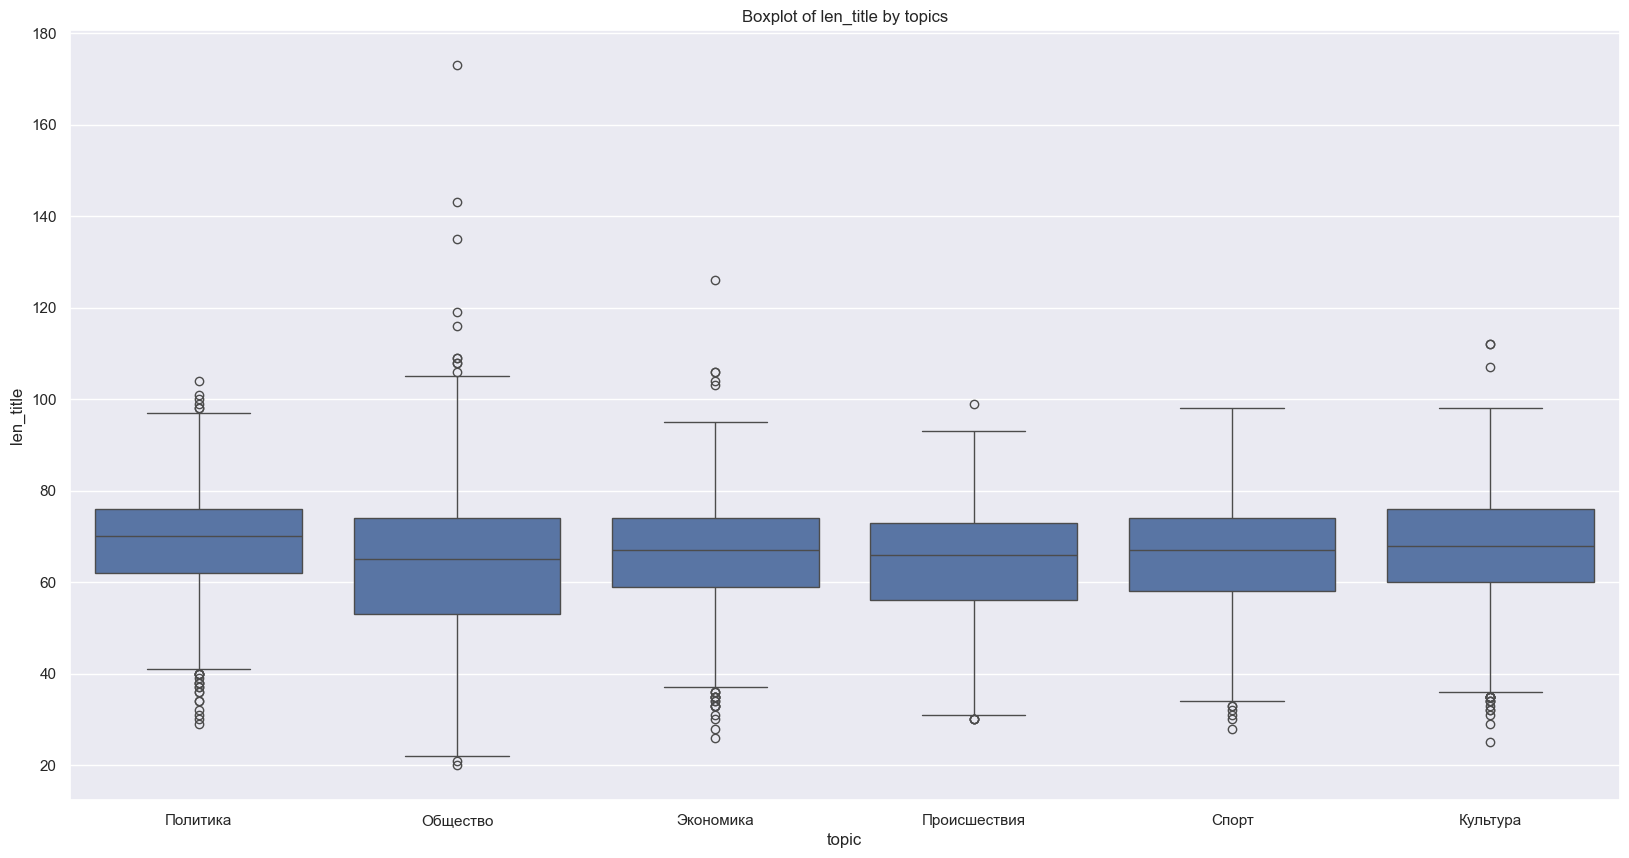

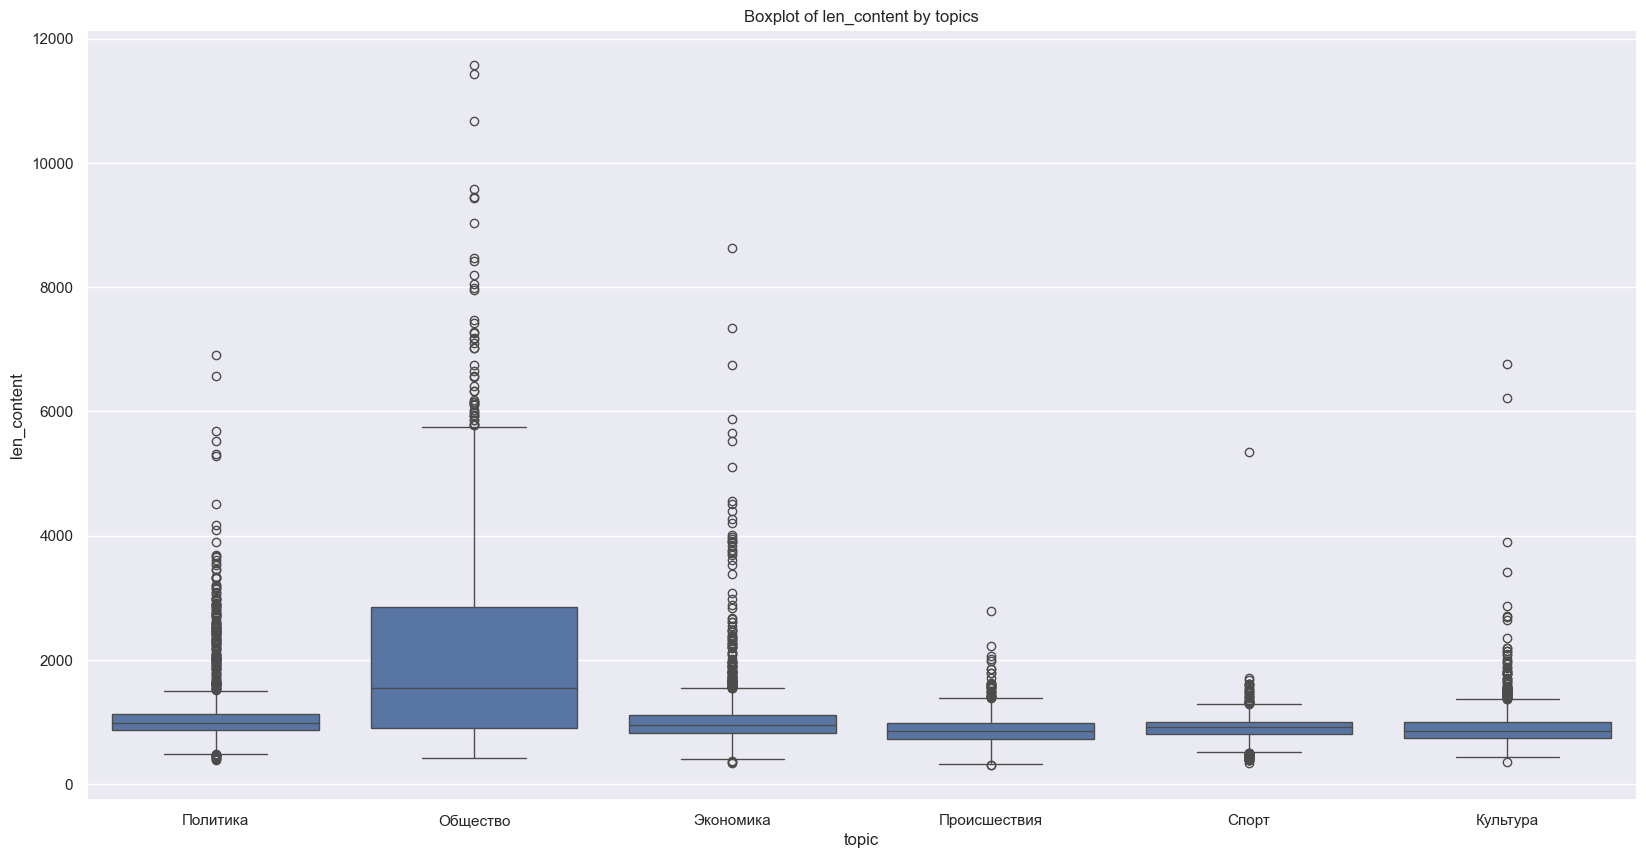

In [68]:
for col in ['len_title', 'len_content']:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
    sns.boxplot(x="topic", y=col, data=df, ax=ax)
    plt.title(f'Boxplot of {col} by topics');

In [69]:
df.drop('datetime', axis=1).describe()

,len_title,len_content
count,11490.000000,11490.000000
mean,65.246301,1255.514621
std,12.539144,961.285944
min,20.000000,307.000000
25%,58.000000,805.000000
50%,67.000000,951.000000
75%,74.000000,1156.000000
max,173.000000,11573.000000


- Мы видим, что средняя длина заголовка равняется 65 знакам, а средняя длина статьи - 1255 знаков (при этом медиана - 951).
- Самыми объемными статьями оказались статьи из раздела "Общество", который содержит самое большое количество статей. Статьи из остальных разделов имеют примерно одинаковые длины статей.
- Присутствует некоторое количество выбросов в длинах заголовков.

Взглянем на то, какие ключевые слова присутствуют в заголовках каждой из тематик.

In [70]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык', 'ноября', 'делать', 'рассказал'])

In [71]:
for topic in df.topic.unique():
    words = df[df.topic == topic].title.str.split(' ').explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

   fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Самые частые слова в заголовках раздела \'{topic}\'", fontsize=30)
    ax.imshow(wc, alpha=0.98)

## Промежуточный анализ

- Мы спарсили статьи с первых 100 страниц сайта osnmedia.ru и нам удалось извлечь 11.8 тысяч статей. Статьи разделились по шести категориям `Общество`, `Политика`, `Экономика`, `Происшествия`, `Спорт` и `Культура`. 
- Нам удалось подготовить датасет, в ходе чего мы очистили названия статей от ненужных символов, привели признак с датой к нужному формату. 
- Проводя разведочный анализ данных, мы создали новые признаки с днём недели и месяцем, в которые выпущены статьи. С помощью этого мы построили гистограмму, на которой выяснили, в какие месяцы ($ноябрь$) и дни недели($вторник и среда$) выпускалось больше всего статей. 
- Также мы проанализировали длины заголовков и самих статей и выяснили, что средней длиной статьи является 65 знаков, а средний размер статьи на сайте - 1255 знаков. 
- В заключении анализа, мы создали облака самых часто встречающихся в заголовках слов по каждому из разделов

# Word2Vec

In [72]:
import sklearn
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from catboost import CatBoostClassifier

import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

import mlxtend
from mlxtend.evaluate import paired_ttest_kfold_cv

from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [73]:
rnd_state = 641

Нам необходимо предобработать текст(лемматизировать и токенизировать). Библиотека Natasha включает в себя все эти методы предобработки и хорошо справляется при работе именно с русским языком. Для этого сохраним классы нашей модели в переменные и создадим функцию, которая будет предобрабатывать текст.

In [74]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [75]:
def text_prep(text) -> str:
    """Проводит токенизацию и лемматизацию с помощью модели Natasha, убирает стоп-слова"""
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    lemmas = [_.lemma for _ in doc.tokens]
    words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [76]:
%%time
df['title_clean'] = df.title.apply(text_prep)
df['content_clean'] = df.content.apply(text_prep)

CPU times: total: 12min 53s
Wall time: 9min 16s


Сравним изначальный и обработанный тексты.

In [77]:
df.sample(1)[['title', 'title_clean']].values

array([['Рогов: ВСУ не успевают затыкать дыры на фронте',
        'рогов всу успевать затыкать дыра фронт']], dtype=object)

In [78]:
df.sample(1)[['content', 'content_clean']].values

array([['  Украинские волонтеры передают военным Вооруженных сил страны наркотические вещества, из-за чего у\xa0большинства солдат возникает зависимость. Об\xa0этом сообщил один из\xa0военнопленных украинских бойцов Дмитрий Гирич. Информацию передали в\xa0Минобороны РФ.«Есть у\xa0нас хлопец, что через волонтеров предоставляет наркотики. Если кому-то нужны „колеса“, он\xa0предоставлял „колеса“, „трава“\xa0— „траву“… Больше половины нашего подразделения сидит на\xa0каких-то наркотиках»,\xa0— проинформировал он.  По\xa0словам Гирича, часто командиры подразделений собирают с\xa0военных деньги якобы на\xa0машины, снаряжение и\xa0беспилотники. При этом после таких сборов никто о\xa0новой технике и\xa0не\xa0вспоминает. Пленный солдат ВСУ предположил, что средства также могут уходить на\xa0покупку наркотических веществ, но\xa0уже для высших командующих чинов\xa0ВСУ.Ранее сообщалось о том, что в Москве задержали полицейского, вымогавшего деньги за подброшенную марихуану. Подробнее об этом читай

Тексты успешно подготовлены к работе, обучим модель Word2Vec на заголовках и проверим близкие по значению слова. 

In [79]:
model = Word2Vec(sentences=df.title_clean.str.split(),
                 vector_size=297,
                 min_count=10,
                 window=2,
                 seed=rnd_state)

In [80]:
model.wv.most_similar(positive=["песков"])

[('призвать', 0.9996744990348816),
 ('заявить', 0.9996702671051025),
 ('москва', 0.9996672868728638),
 ('российский', 0.9996591806411743),
 ('страна', 0.9996532201766968),
 ('сша', 0.9996531009674072),
 ('ребенок', 0.9996516108512878),
 ('рассказать', 0.999648928642273),
 ('глава', 0.9996469020843506),
 ('дело', 0.9996443390846252)]

Разделим датасет на обучающую и тестовую выборки и приступим к обучению моделей.

In [81]:
X_train, X_test, y_train, y_test = train_test_split(df.content_clean.str.split(),
                                                    df.topic.values,
                                                    random_state=rnd_state, train_size=0.8)

model = Word2Vec(sentences=X_train,
                 vector_size=200,
                 min_count=10,
                 window=2,
                 seed=rnd_state)

## MeanEmbedding + Логистическая регрессия

Создадим класс MeanEmbeddingVectorizer, с помощью которого мы усредним все слова в предложении и получим некоторый смысл всего предложения (если слова не окажется в тексте, то  мы возьмём нулевой вектор).

In [82]:
class MeanEmbeddingVectorizer(object):
    """Get mean of vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.dim = model.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.get_vector(w)
                for w in words if w in self.word2vec] or
                [np.zeros(self.dim)], axis=0)
            for words in X])

In [83]:
pipe = Pipeline([('w2v', MeanEmbeddingVectorizer(model)),
                 ('clf', LogisticRegression(random_state=rnd_state,
                                            max_iter=1000))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

    Культура       0.92      0.91      0.92       340
    Общество       0.82      0.79      0.81       606
    Политика       0.77      0.88      0.82       339
Происшествия       0.83      0.86      0.84       348
       Спорт       0.97      0.93      0.95       320
   Экономика       0.88      0.84      0.86       345

    accuracy                           0.86      2298
   macro avg       0.87      0.87      0.87      2298
weighted avg       0.86      0.86      0.86      2298



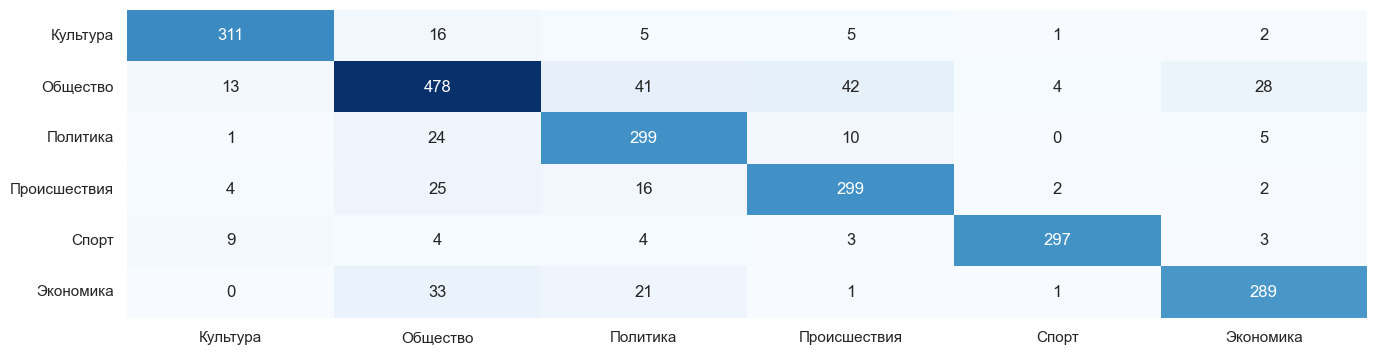

In [84]:
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

## TF-IDF + Метод Опорных Векторов(SVM)

In [85]:
class TfidfEmbeddingVectorizer(object):
    """Получает векторы взвешенные по tf-idf"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.word2weight = None
        self.dim = model.vector_size

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec.get_vector(w) * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [86]:
pipe = Pipeline([('tfidf', TfidfEmbeddingVectorizer(model)),
                 ('clf', SVC(decision_function_shape='ovo', class_weight='balanced', random_state=rnd_state))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

    Культура       0.89      0.93      0.91       340
    Общество       0.90      0.73      0.81       606
    Политика       0.75      0.92      0.83       339
Происшествия       0.81      0.89      0.85       348
       Спорт       0.99      0.92      0.95       320
   Экономика       0.84      0.87      0.86       345

    accuracy                           0.86      2298
   macro avg       0.86      0.88      0.87      2298
weighted avg       0.87      0.86      0.86      2298



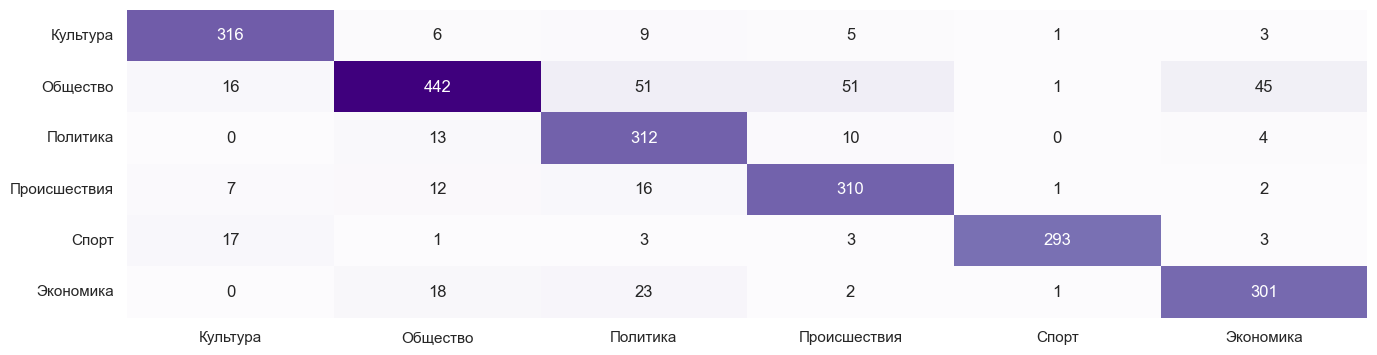

In [87]:
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap='Purples', fmt='d', cbar=False);

## TF-IDF + CatBoost Classifier

In [88]:
pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(model)),
                 ('clf', CatBoostClassifier(random_state=rnd_state, verbose=False))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

    Культура       0.93      0.93      0.93       340
    Общество       0.86      0.81      0.83       606
    Политика       0.80      0.91      0.85       339
Происшествия       0.84      0.87      0.86       348
       Спорт       0.98      0.95      0.97       320
   Экономика       0.88      0.85      0.87       345

    accuracy                           0.88      2298
   macro avg       0.88      0.89      0.88      2298
weighted avg       0.88      0.88      0.88      2298



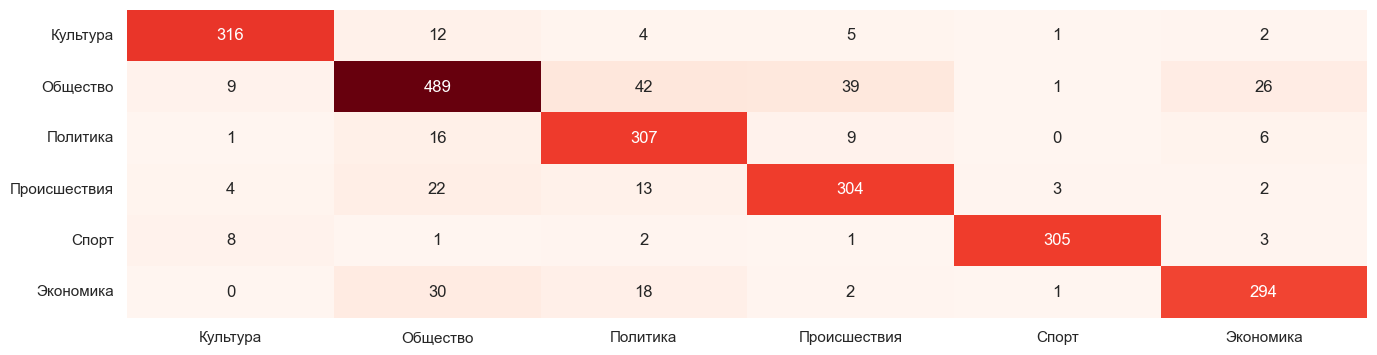

In [89]:
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap='Reds', fmt='d', cbar=False);

## Промежуточный вывод
На нашем корпусе текстов мы обучили и проверили точность трёх моделей: `Логистической регрессии`, `Метода опорных векторов` и  `CatBoost Classifier`. Все они показали схожие результаты и работу всех моделей можно считать адекватной, однако самой точной, но при этом самой долгой оказалась модель `CatBoost`: её 'Accuracy' равен $0.88$. Чаще всего модель ошибалась в классификации текстов разделов "Общество", "Политика" и "Проишествия", что не удивительно, ведь они могут быть схожи по содержанию и смыслу, имеют множество общих тем, что в том числе заставляет задуматься, о том, насколько сейчас политка вплетена в повседневную жизнь нашего общества. Лучше всего модель справилась с классификацией разделов "Культура" и "Спорт", что доказывает адекватность работы модели, ведь эти разделы как раз имеют самые чёткие смысловые и тематические рамки.